# LONG SHORT TERM MEMORY (LSTM)

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf
import random

# Import Dataset

In [29]:
# Set the random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Import Dataset
 # EUR - VND
eur = pd.read_csv('EUR.csv')
 # GBP - VND
gbp = pd.read_csv("GBP.csv")
 # JPY - VND
jpy = pd.read_csv("JPY.csv")
# Convert
eur = eur['Sale'].replace({',':''}, regex=True).astype(float)
gbp = gbp['Sale'].replace({',':''}, regex=True).astype(float)
jpy = jpy['Sale'].replace({',':''}, regex=True).astype(float)

# Scaler model
scaler=MinMaxScaler(feature_range=(0,1))


# Function to standardize the data

In [30]:
def standardizate_data(train, test, pre_test, f3, f6, f9):
    # Train
    train = np.reshape(train, (-1,1))
    train1 = scaler.inverse_transform(train)
    # Test
    test = np.reshape(test, (-1,1))
    test1 = scaler.inverse_transform(test)
    # Test prediction
    pre_test = np.reshape(pre_test, (-1,1))
    pre_test1 = scaler.inverse_transform(pre_test)
    # Forecast 30
    f3 = np.reshape(f3, (-1,1))
    f3_tf= scaler.inverse_transform(f3)
    # Forecast 60
    f6 = np.reshape(f6, (-1,1))
    f6_tf= scaler.inverse_transform(f6)
    # Forecast 90
    f9 = np.reshape(f9, (-1,1))
    f9_tf= scaler.inverse_transform(f9)
    
    return train1, test1, pre_test1, f3_tf, f6_tf, f9_tf 


### Convert-data Function

In [31]:
# Convert train, test data into X_train, y_train, X_test, y_test
# Function to convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

# Function to convert data
def convert_data(train, test, time_step):
    # Reshape into X = t, t+1, t+2 ,..., t+99 and Y = t+100
    X_train, y_train = create_dataset(train, time_step)
    X_test, y_test = create_dataset(test, time_step)
    # Reshape input to be [samples, time steps, features] which is required for LSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # => 3D
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    return X_train, y_train, X_test, y_test



# Function to forecast next 30, 60, 90 days data

In [32]:
def forecast_days(model, test):
    x_input = test[len(test)-40:].reshape(1, -1)

    temp_input = list(x_input)
    temp_input = temp_input[0].tolist()

    forecast30 = []
    forecast60 = []
    forecast90 = []
    n_steps = 40
    i = 0
    while(i <= 90):
        if(len(temp_input) > 40):
            x_input = np.array(temp_input[1:])
            print("{} day input {}".format(i, x_input))
            x_input = x_input.reshape(1, -1)
            x_input = x_input.reshape((1, n_steps, 1))  # 3D
            yhat = model.predict(x_input, verbose=0)
            print("{} day output {}".format(i, yhat))
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            if i <= 30:
                forecast30.extend(yhat.tolist())
            elif i <= 60:
                forecast60.extend(yhat.tolist())
            else:
                forecast90.extend(yhat.tolist())
            i = i + 1
        else:
            x_input = x_input.reshape((1, n_steps, 1))
            yhat = model.predict(x_input, verbose=0)
            print(yhat[0])
            temp_input.extend(yhat[0].tolist())
            print(len(temp_input))
            forecast30.extend(yhat.tolist())
            i = i + 1
    return forecast30, forecast60, forecast90

# Function to visualize the model

In [33]:
def visualize_LSTM(model, train, test, pre_test, f3, f6, f9):
    # set index
    # set train, test index
    index = pd.date_range(start='3/1/2019', periods=len(train) + len(test), freq='d')
    # set forecast index
    forecast_index = pd.date_range(start='6/1/2024', periods=91, freq='d')
    
    # Visualize
    plt.figure(figsize=(12, 6))
    plt.plot(index[:len(train)], scaler.inverse_transform(train))
    plt.plot(index[len(train):], scaler.inverse_transform(test))
    plt.plot(index[len(train)+40:], scaler.inverse_transform(pre_test))
    plt.plot(forecast_index[:31], scaler.inverse_transform(f3))
    plt.plot(forecast_index[31:61], scaler.inverse_transform(f6))
    plt.plot(forecast_index[61:], scaler.inverse_transform(f9))

    # Highlight the transition point from test data to predictions
    transition_point = pd.Timestamp('2024-06-01')
    plt.axvline(x=transition_point, color='r', linestyle='--', label='01/06/2024')

    plt.title('LSTM Time Series Forecast')
    plt.xlabel('Date')
    plt.ylabel('Exchange Rate (VND)')
    plt.legend(['Train', 'Test', 'TestPred', 'Forecast 30 days next', 'Forecast 60 days next', 'Forecast 90 days next', '01/06/2024'])
    plt.show()


# Function to evaluate the model

In [34]:
def evaluate(forecast, actual):
    forecast = np.array(forecast)
    actual = np.array(actual)
    mape = np.mean(np.abs(forecast - actual) / np.abs(actual)) * 100  # MAPE
    mae = np.mean(np.abs(forecast - actual))  # MAE
    rmse = np.mean((forecast - actual) ** 2) ** .5  # RMSE

    print('RMSE =', rmse)
    print('MAPE(%) =', mape)
    print('MAE =', mae)

### Function to implement LSTM

In [35]:
def implement_LSTM(train, test):
    time_step = 40
    # Convert Train, Test data
    X_train, y_train, X_test, y_test = convert_data(train, test, time_step)

    # Define LSTM model
    model = Sequential()
    model.add(LSTM(50, input_shape=(time_step, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Fit model
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

    # Predict Test data
    pre_test = model.predict(X_test)

    # Forecast next 30, 60, 90 days data
    forecast30, forecast60, forecast90 = forecast_days(model, test)

    # Visualize model
    visualize_LSTM(model, train, test, pre_test, forecast30, forecast60, forecast90)

    # Standardize
    train, test, pre_test, forecast30, forecast60, forecast90 = standardizate_data(train, test, pre_test, forecast30, forecast60, forecast90)

    # Measure accuracy
    evaluate(pre_test, test[40:])



# EUR_VND

In [36]:
# Scale data
eur_sc = scaler.fit_transform(np.array(eur).reshape(-1, 1))
# Split train, test data
## case 1. 7:3
train_eur_1_sc = eur_sc[:int(0.7 * len(eur))]
test_eur_1_sc = eur_sc[int(0.7 * len(eur)):]
## case 2. 8:2
train_eur_2_sc = eur_sc[:int(0.8 * len(eur))]
test_eur_2_sc = eur_sc[int(0.8 * len(eur)):]
## case 3. 9:1
train_eur_3_sc = eur_sc[:int(0.9 * len(eur))]
test_eur_3_sc = eur_sc[int(0.9 * len(eur)):]



EUR_7:3

c:\Users\Windows\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.2023 - val_loss: 0.0030
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0061 - val_loss: 0.0018
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0037 - val_loss: 0.0016
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0

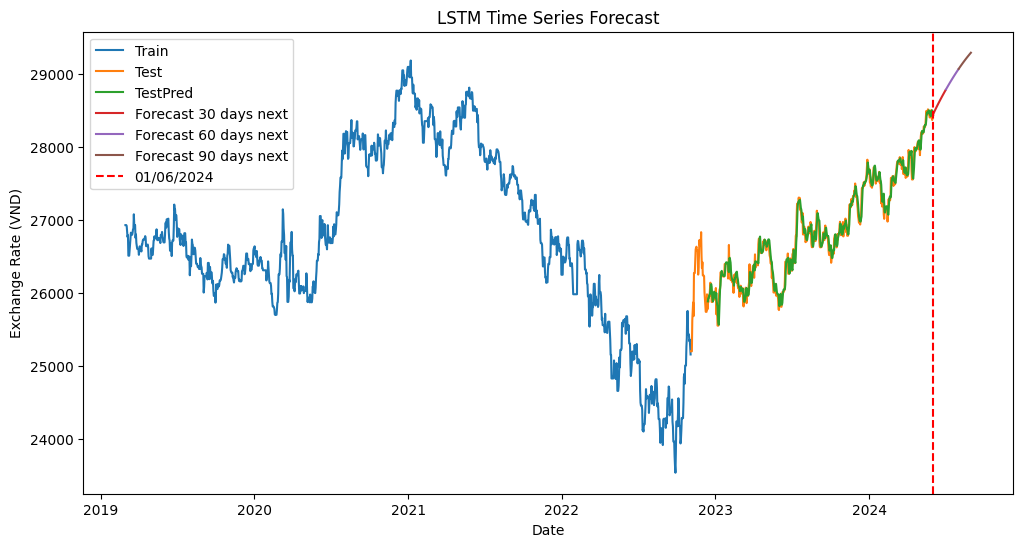

RMSE = 100.89092948786006
MAPE(%) = 0.2786334943919517
MAE = 74.6509408523789


In [37]:
implement_LSTM(train_eur_1_sc, test_eur_1_sc)

EUR_8:2

Epoch 1/100


c:\Users\Windows\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1704 - val_loss: 0.0035
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0063 - val_loss: 0.0013
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - val_loss: 0.0010
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0022 - val_loss: 9.8871e-04
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0018 - val_loss: 9.5805e-04
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016 - val_loss: 9.4943e-04
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016 - val_loss: 9.4619e-04
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016 - val_loss: 9.3829e-04
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0016 - val_loss: 9.2932e-04
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0015 - val_loss: 9.2030e-04
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0015 - val_loss: 9.1125e-04
Epoch 12/100
24/24 ━━━━━━━━━━━━━

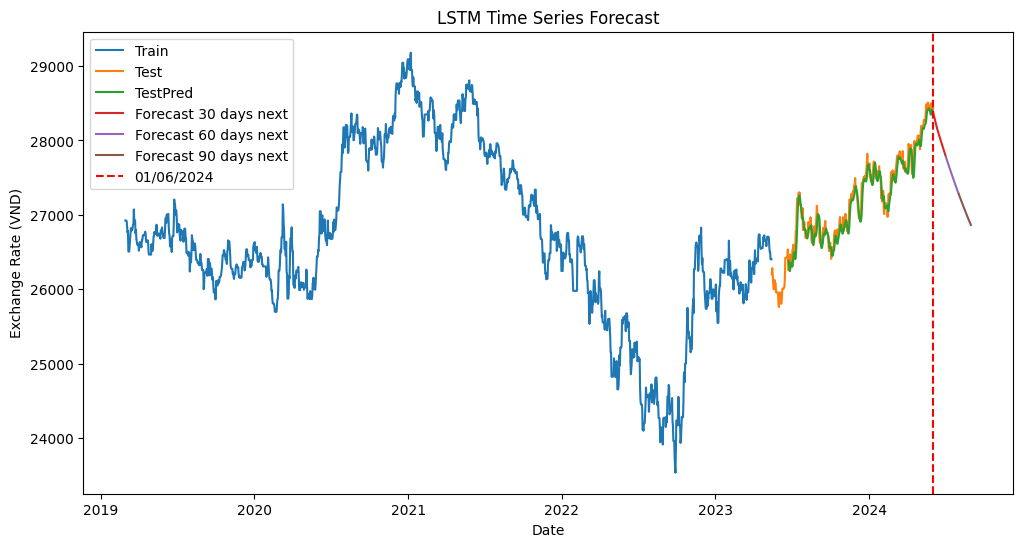

RMSE = 119.58808109202995
MAPE(%) = 0.33650218810221355
MAE = 91.76545466933156


In [38]:
implement_LSTM(train_eur_2_sc, test_eur_2_sc)

EUR_9:1

Epoch 1/100


c:\Users\Windows\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0958 - val_loss: 0.0155
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0052 - val_loss: 0.0036
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016 - val_loss: 8.2735e-04
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014 - val_loss: 6.8692e-04
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013 - val_loss: 6.5221e-04
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0013 - val_loss: 6.3599e-04
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012 - val_loss: 6.2803e-04
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012 - val_loss: 6.2114e-04
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012 - val_loss: 6.1439e-04
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012 - val_loss: 6.0793e-04
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━

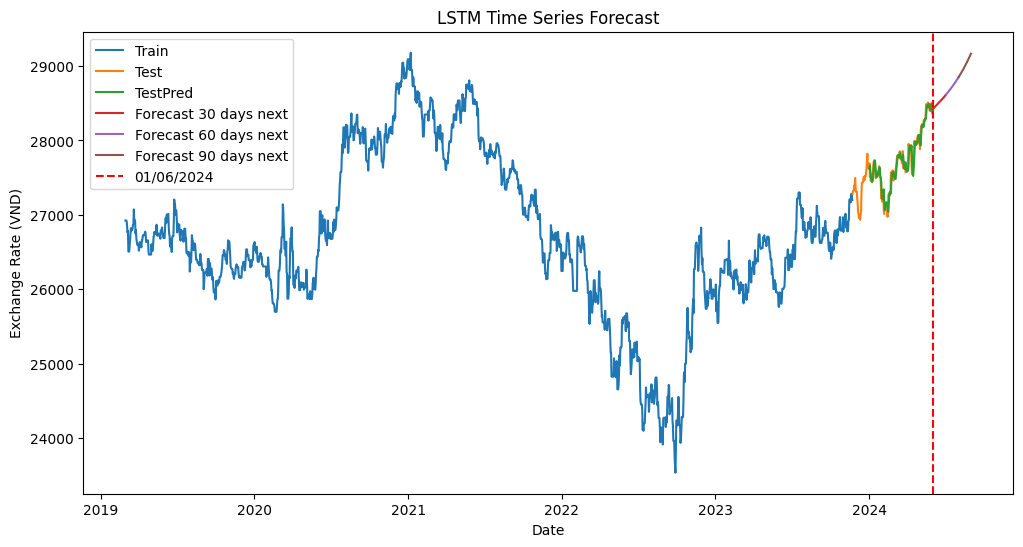

RMSE = 88.4183656847581
MAPE(%) = 0.2273271498488849
MAE = 62.92837685032914


In [39]:
implement_LSTM(train_eur_3_sc, test_eur_3_sc)

# GBP_VND

In [40]:
# Scale data
gbp_sc = scaler.fit_transform(np.array(gbp).reshape(-1, 1))
# Split train, test data
## case 1. 7:3
train_gbp_1_sc = gbp_sc[:int(0.7 * len(gbp))]
test_gbp_1_sc = gbp_sc[int(0.7 * len(gbp)):]
## case 2. 8:2
train_gbp_2_sc = gbp_sc[:int(0.8 * len(gbp))]
test_gbp_2_sc = gbp_sc[int(0.8 * len(gbp)):]
## case 3. 9:1
train_gbp_3_sc = gbp_sc[:int(0.9 * len(gbp))]
test_gbp_3_sc = gbp_sc[int(0.9 * len(gbp)):]



GBP_7:3

Epoch 1/100


c:\Users\Windows\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.3054 - val_loss: 0.0115
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0093 - val_loss: 0.0026
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0043 - val_loss: 0.0028
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0034 - val_loss: 0.0017
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0028 - val_loss: 0.0014
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0

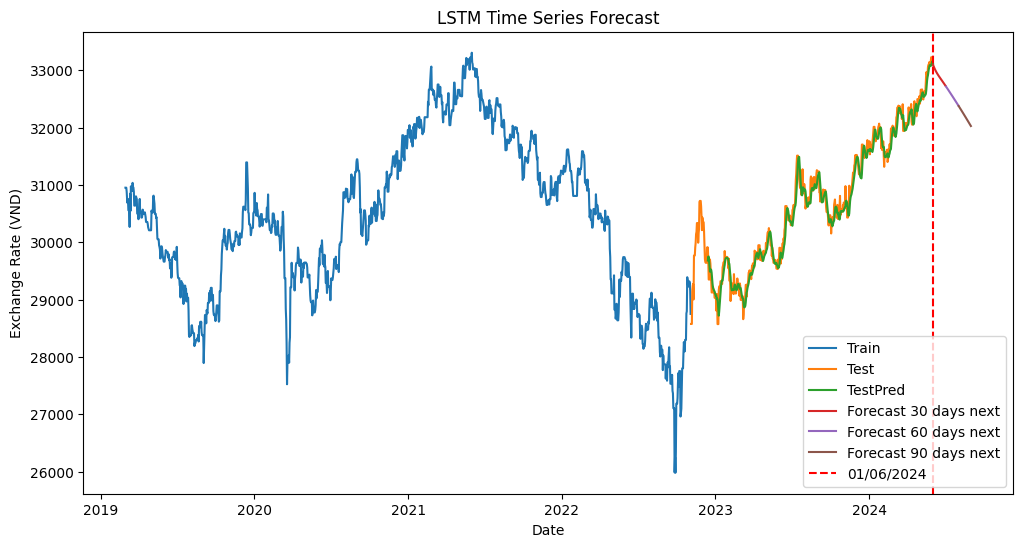

RMSE = 158.1500612248469
MAPE(%) = 0.40042538155200075
MAE = 122.96790461753734


In [41]:
implement_LSTM(train_gbp_1_sc, test_gbp_1_sc)

GBP_8:2

Epoch 1/100


c:\Users\Windows\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1961 - val_loss: 0.0021
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0057 - val_loss: 0.0012
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - val_loss: 0.0017
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0021 - val_loss: 0.0010
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0018 - val_loss: 8.3256e-04
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - val_loss: 7.6637e-04
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0017 - val_loss: 7.4612e-04
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0017 - val_loss: 7.3528e-04
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0017 - val_loss: 7.2521e-04
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0016 - val_loss: 7.1552e-04
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s

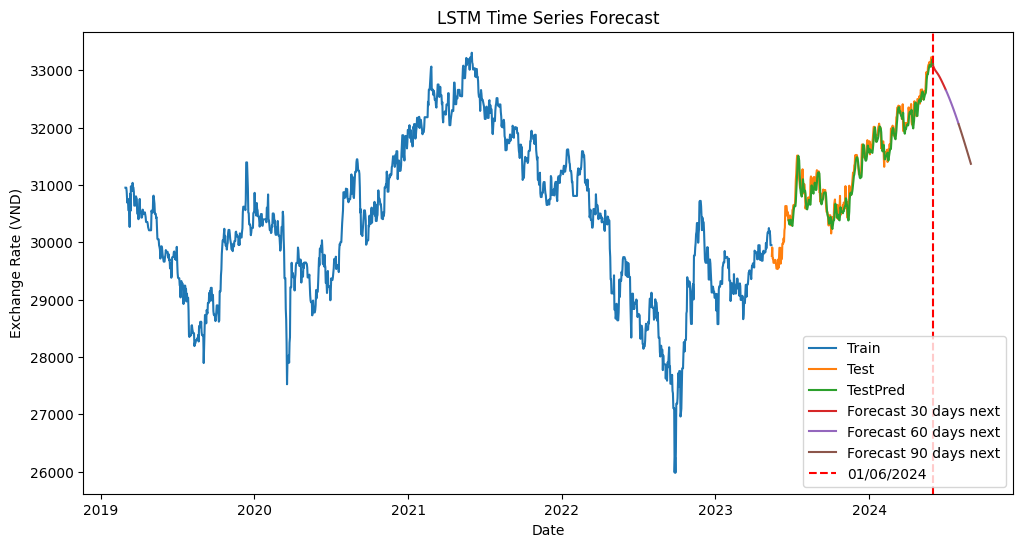

RMSE = 141.34641561966185
MAPE(%) = 0.34683270300143204
MAE = 109.0175497365553


In [42]:
implement_LSTM(train_gbp_2_sc, test_gbp_2_sc)

GBP_9:1

Epoch 1/100


c:\Users\Windows\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.2085 - val_loss: 0.0237
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0074 - val_loss: 0.0046
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0029 - val_loss: 0.0034
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0018 - val_loss: 8.4940e-04
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0017 - val_loss: 7.6521e-04
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0017 - val_loss: 7.2631e-04
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0017 - val_loss: 7.0899e-04
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016 - val_loss: 7.0280e-04
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1

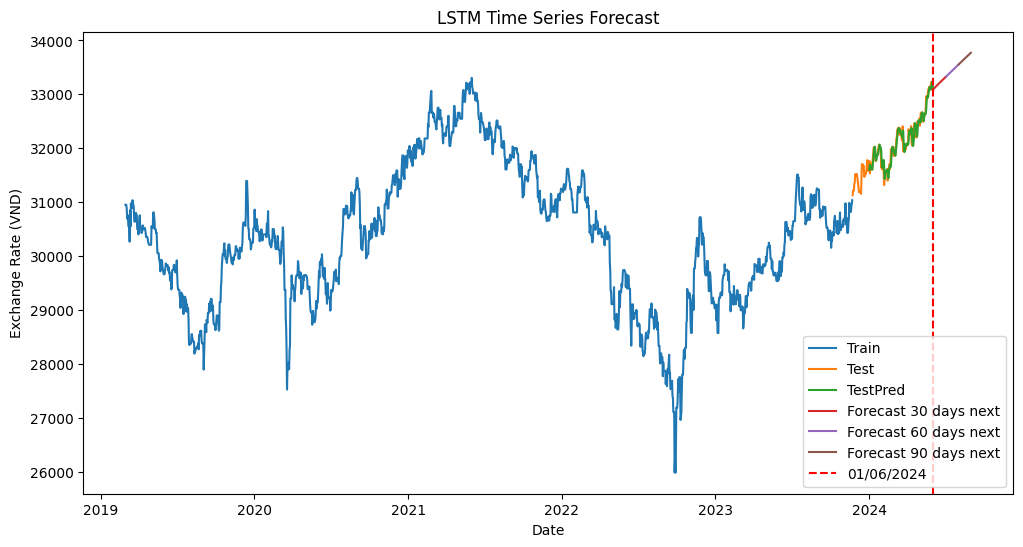

RMSE = 111.6237060633534
MAPE(%) = 0.25712599702043965
MAE = 82.5672157689146


In [43]:
implement_LSTM(train_gbp_3_sc, test_gbp_3_sc)

# JPY_VND

In [44]:
# Scale data
jpy_sc = scaler.fit_transform(np.array(jpy).reshape(-1, 1))
# Split train, test data
## case 1. 7:3
train_jpy_1_sc = jpy_sc[:int(0.7 * len(jpy))]
test_jpy_1_sc = jpy_sc[int(0.7 * len(jpy)):]
## case 2. 8:2
train_jpy_2_sc = jpy_sc[:int(0.8 * len(jpy))]
test_jpy_2_sc = jpy_sc[int(0.8 * len(jpy)):]
## case 3. 9:1
train_jpy_3_sc = jpy_sc[:int(0.9 * len(jpy))]
test_jpy_3_sc = jpy_sc[int(0.9 * len(jpy)):]



JPY_7:3

Epoch 1/100


c:\Users\Windows\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.3284 - val_loss: 0.0165
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0078 - val_loss: 0.0161
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0043 - val_loss: 0.0093
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0027 - val_loss: 0.0068
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0019 - val_loss: 0.0044
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.9863e-04 - val_loss: 0.0012
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.1338e-04 - val_loss: 9.4445e-04
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.7424e-04 - val_loss: 8.3738e-04
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.5723e-04 - val_loss: 7.9154e-04
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━

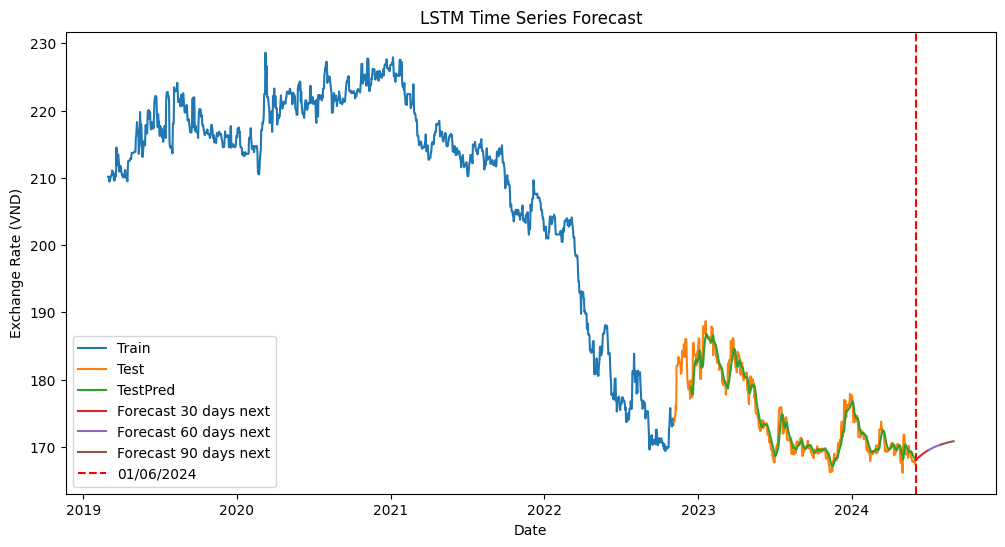

RMSE = 1.3959249453895068
MAPE(%) = 0.5755408254996641
MAE = 1.0100864831725165


In [45]:
implement_LSTM(train_jpy_1_sc, test_jpy_1_sc)

JPY_8:2

Epoch 1/100


c:\Users\Windows\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1756 - val_loss: 0.0104
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0065 - val_loss: 0.0103
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0027 - val_loss: 0.0049
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0011 - val_loss: 9.6986e-04
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.2411e-04 - val_loss: 6.1622e-04
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.8606e-04 - val_loss: 5.2762e-04
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.7874e-04 - val_loss: 5.0730e-04
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.7505e-04 - val_loss: 5.0311e-04
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.7168e-04 - val_loss: 5.0266e-04
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.6804e-04 - val_loss: 5.0255e-04
Epoch 12/100

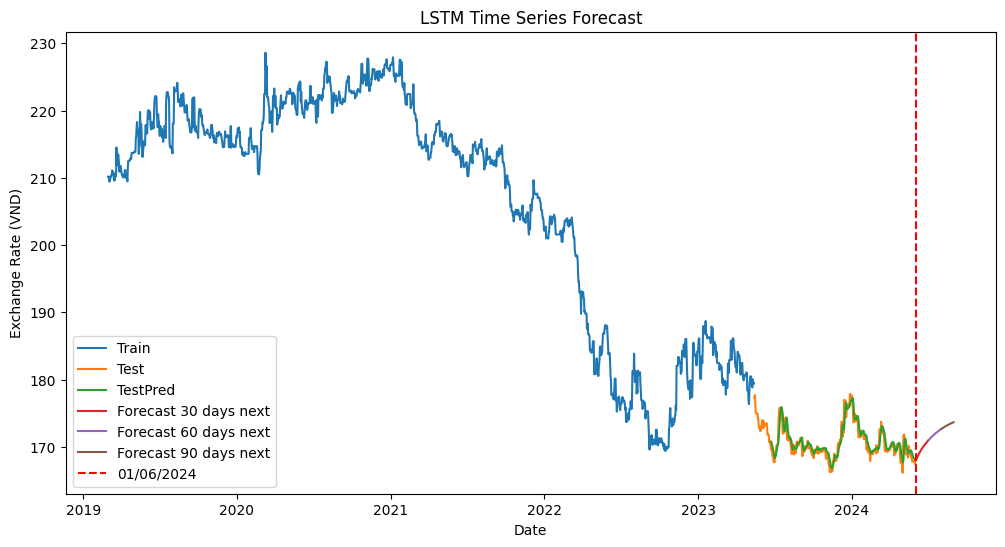

RMSE = 1.038640245951125
MAPE(%) = 0.4476713916179317
MAE = 0.7648852929403621


In [46]:
implement_LSTM(train_jpy_2_sc, test_jpy_2_sc)

JPY_9:1

Epoch 1/100


c:\Users\Windows\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.2186 - val_loss: 0.0093
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0092 - val_loss: 0.0058
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0013 - val_loss: 5.7790e-04
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0011 - val_loss: 4.5885e-04
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0011 - val_loss: 4.6116e-04
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0011 - val_loss: 4.7211e-04
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011 - val_loss: 4.7703e-04
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011 - val_loss: 4.7991e-04
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0011 - val_loss: 4.8216e-04
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0011 - val_loss: 4.8348e-04
Epoch 12/100
27/27 ━━━━━━━━━━━━━

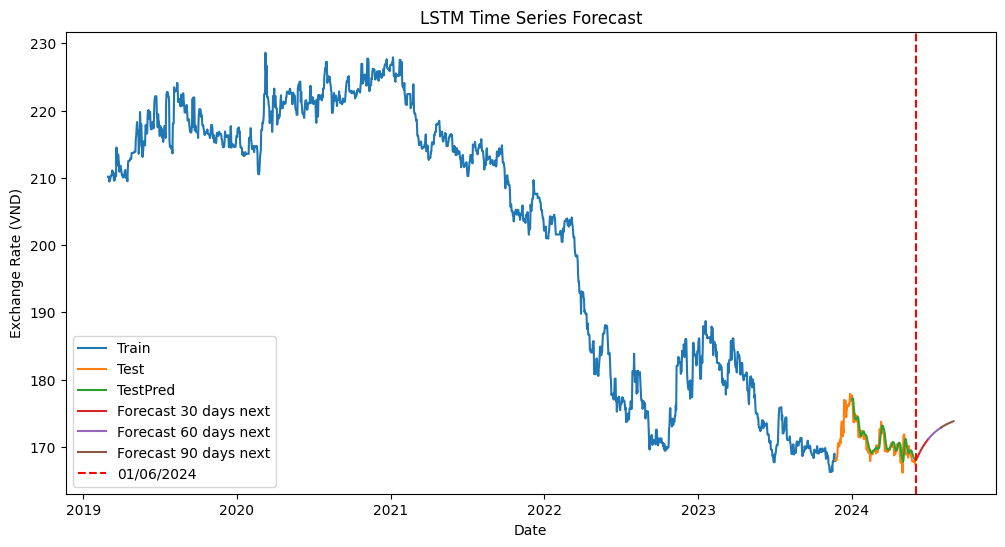

RMSE = 1.092211687217055
MAPE(%) = 0.47865594019386515
MAE = 0.8155361938476576


In [47]:
implement_LSTM(train_jpy_3_sc, test_jpy_3_sc)